In [1]:
from concurrent.futures import ThreadPoolExecutor
from torch.utils.data import Dataset, DataLoader
from scipy.spatial import distance
from tqdm.notebook import tqdm
from PIL import Image
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import warnings
import random
import torch
import time
import cv2
import os
import gc

warnings.filterwarnings("ignore")

In [2]:
def get_batch_size(device, min_batch_size=8, max_batch_size=64):
    device_id = int(device.split(':')[1])
    gpu_mem = torch.cuda.get_device_properties(device_id).total_memory / 1e9  
    free_mem = gpu_mem - torch.cuda.memory_allocated(device_id) / 1e9
    batch_size = max(min_batch_size, min(max_batch_size, int(free_mem * 4)))
    torch.cuda.empty_cache()
    return batch_size

In [3]:
class CFG:
    dataset_path = "/kaggle/input/byu-locating-bacterial-flagellar-motors-2025/"
    test_image_path = os.path.join(dataset_path, "test")
    model_paths = [
        "/kaggle/input/flagellar-motor-detection-2-3-yolo-training/byu-locating-bacterial-flagellar-motors/yolo11s_fold_0/weights/best.torchscript"
    ]
    
    seed = 42    
    devices = ['cuda:0', 'cuda:1']
    image_size = 640
    box_size = 64
    confidence_threshold = 0.4
    nms_iou_threshold = 0.2
    concentration = 1
    
    batch_sizes = [get_batch_size(device_id) for device_id in devices]

In [4]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

torch.manual_seed(CFG.seed)
random.seed(CFG.seed)
np.random.seed(CFG.seed)

In [5]:
class GPUProfiler:        
    def __enter__(self):
        torch.cuda.synchronize()
        return self
        
    def __exit__(self, *args):
        torch.cuda.synchronize()

In [6]:
class TomogramDataset(Dataset):
    def __init__(self,tomo_dir, files, image_size=CFG.image_size):
        self.tomo_dir = tomo_dir
        self.files = files
        self.image_size = image_size

    def __getitem__(self, index):
        image_path = os.path.join(self.tomo_dir, self.files[index])
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        if image is None:
            image = np.array(Image.open(image_path))
            
        processed_image = self.preprocess(image)
        z_index = int(self.files[index].split('_')[1].split('.')[0])
        
        return *processed_image, z_index
        
    def __len__(self):
        return len(self.files)
    
    def preprocess(self, image):
        image, ratio, pad_w, pad_h = self.letterbox(image)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        image = image.transpose(2, 0, 1)
        image = np.ascontiguousarray(image, dtype=np.float32) / 255.0
        img_tensor = torch.from_numpy(image)
        return img_tensor, ratio, pad_w, pad_h

    def letterbox(self, image, color=(114, 114, 114), min_pad=0):
        new_w, new_h = self.image_size, self.image_size
        h, w = image.shape[:2]
        ratio = min(new_w / w, new_h / h ) 
        
        new_unpad_w,new_unpad_h  = (int(round(w * ratio) - 2 * min_pad), int(round(h * ratio)) - 2 * min_pad)
        ratio = min(new_unpad_w / w, new_unpad_h / h)
        dw, dh = new_w - new_unpad_w, new_h - new_unpad_h

        dw /= 2  
        dh /= 2

        image_resized = cv2.resize(image, (new_unpad_w,new_unpad_h), interpolation=cv2.INTER_LINEAR)
        image_resized = self.normalize(image_resized)
        top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
        left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
        image_padded = cv2.copyMakeBorder(image_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

        return image_padded, ratio, left, top
    
    def normalize(self, image):
        p2, p98 = np.percentile(image, [2, 98])
        clipped_data = np.clip(image, p2, p98)
        normalized = 255 * (clipped_data - p2) / (p98 - p2)
        return np.uint8(normalized)

In [7]:
def perform_3d_nms(detections, distance_threshold=CFG.nms_iou_threshold):
    if not detections:
        return []

    detections = sorted(detections, key=lambda x: x['confidence'], reverse=True)
    final_detections = []

    def distance_3d(d1, d2):
        return np.sqrt((d1['z'] - d2['z'])**2 + (d1['y'] - d2['y'])**2 + (d1['x'] - d2['x'])**2)

    while detections:
        best_detection = detections.pop(0)

        final_detections.append(best_detection)

        detections = [d for d in detections if distance_3d(d, best_detection) > distance_threshold]
        
    return final_detections

In [8]:
def infer_batch(model, device_idx, img_tensor, ratios, paddings, conf_thres=CFG.confidence_threshold):
    img_tensor = img_tensor.to(device_idx)
    
    with torch.no_grad():
        with torch.amp.autocast(device_type='cuda', enabled=True, dtype=torch.float16):
            outputs = model(img_tensor) 
            
    outputs = outputs.cpu()
    if "10m" in CFG.model_paths[0]:
        outputs = outputs.permute(0, 2, 1)
        
    batch_results = []
    for i, output in enumerate(outputs):
        if "10m" in CFG.model_paths[0]:
            x_center, y_center, width, height, confidence, _ = output
        else:
            x_center, y_center, width, height, confidence = output
            
        mask = confidence > conf_thres

        x, y, w, h, conf = x_center[mask], y_center[mask], width[mask], height[mask], confidence[mask]
        ratio, pad_w, pad_h = ratios[i], paddings[0][i], paddings[1][i]
        x1, y1, x2, y2 = (x - w / 2 - pad_w) / ratio, (y - h / 2 - pad_h) / ratio, (x + w / 2 - pad_w) / ratio, (y + h / 2 - pad_h) / ratio
        batch_results.append((np.stack((x1, y1, x2, y2), axis=1), conf.numpy()))

    return batch_results

In [9]:
def process_tomogram(tomo_id, models, device_idx):
    tomo_dir = os.path.join(CFG.test_image_path, tomo_id)
    slice_files = sorted([f for f in os.listdir(tomo_dir) if f.endswith('.jpg')])
    selected_indices = np.linspace(0, len(slice_files)-1, int(len(slice_files) * CFG.concentration))
    selected_indices = np.round(selected_indices).astype(int)
    slice_files = [slice_files[i] for i in selected_indices]

    batch_size = CFG.batch_sizes[device_idx]
    streams = [torch.cuda.Stream(device=device_idx) for _ in range(min(4, batch_size))]
    dataloader = DataLoader(
        TomogramDataset(tomo_dir, slice_files), 
        batch_size=batch_size, 
        num_workers=1
    )

    all_detections = []
    for batch in tqdm(dataloader, desc=tomo_id):
        images, ratios, paddings_w, paddings_h, indexes = batch

        sub_batches = (
            torch.tensor_split(images, len(streams)),
            torch.tensor_split(ratios, len(streams)),
            torch.tensor_split(paddings_w, len(streams)),
            torch.tensor_split(paddings_h, len(streams)),
            torch.tensor_split(indexes, len(streams))
        )

        for i, (sub_images, sub_ratios, sub_paddings_w, sub_paddings_h, sub_indexes) in enumerate(zip(*sub_batches)):
            if len(sub_images) == 0:
                continue
            
            for fold_idx, model in enumerate(models):
                
                stream = streams[i % len(streams)]
                with torch.cuda.stream(stream):
                    with GPUProfiler():
                        sub_results = infer_batch(model, device_idx, sub_images, sub_ratios, (sub_paddings_w, sub_paddings_h))

                    for k, (boxes, confs) in enumerate(sub_results):
                        for box, conf in zip(boxes, confs):
                            x1, y1, x2, y2 = box
                            x_center = (x1 + x2) / 2
                            y_center = (y1 + y2) / 2
                            all_detections.append({
                                'z': sub_indexes[k].item(),
                                'y': round(y_center),
                                'x': round(x_center),
                                'confidence': float(conf),
                                'fold': fold_idx,
                                'tomo_id': tomo_id
                            })

        torch.cuda.synchronize()
        torch.cuda.empty_cache()
        
    if len(all_detections) == 0:
        return [{
            'z': -1,
            'y': -1,
            'x': -1,
            'confidence': 0,
            'fold': -1,
            'tomo_id': tomo_id
        }]

    return all_detections

In [10]:
models = {}

for device in CFG.devices:
    models[device] = []
    for path in CFG.model_paths:
        models[device].append(torch.jit.load(path, map_location=device).eval())

In [11]:
# %%time

all_detections = []
future_to_tomo = {}
test_tomos = sorted([d for d in os.listdir(CFG.test_image_path) if os.path.isdir(os.path.join(CFG.test_image_path, d))])

with ThreadPoolExecutor(max_workers=len(CFG.devices)) as executor:
    for i, tomo_id in enumerate(test_tomos):
        device_idx = i % len(CFG.devices)
        future = executor.submit(process_tomogram, tomo_id, models[CFG.devices[device_idx]], device_idx)
        future_to_tomo[future] = tomo_id
        
for future, tomo_id in future_to_tomo.items():
    try:
        result = future.result()
        all_detections.extend(result)
        
    except Exception as e:
        all_detections.extend([{
            'z': -1,
            'y': -1,
            'x': -1,
            'confidence': 0,
            'fold': -1,
            'tomo_id': tomo_id
        }])
        print(e)
    
    finally:
        torch.cuda.empty_cache()
        gc.collect()

tomo_003acc:   0%|          | 0/8 [00:00<?, ?it/s]

tomo_00e047:   0%|          | 0/5 [00:00<?, ?it/s]

tomo_01a877:   0%|          | 0/5 [00:00<?, ?it/s]

In [12]:
all_detections = pd.DataFrame(all_detections)
if all_detections.tomo_id.nunique() == 3:
    all_detections.to_csv("all_detections.csv", index=False)

In [13]:
def postprocess(df, confidence_threshold, group_distance_threshold, min_detection_per_group):
    df = df[df['confidence'] >= confidence_threshold]
    
    df_agg_det_tomo_list = []
    for tomo_id, df_det_tomo in df.groupby('tomo_id'):
        dist_mat = distance.cdist(df_det_tomo[['x', 'y', 'z']], df_det_tomo[['x', 'y', 'z']], metric='euclidean')
        adj_mat = (dist_mat <= group_distance_threshold).astype(int)
        np.fill_diagonal(adj_mat, 0)
        G = nx.from_numpy_array(adj_mat)
        connected_components = list(nx.connected_components(G))
        agg_det_dict_list = []
        for group_idx_set in connected_components:
            df_det_grp = df_det_tomo.iloc[list(group_idx_set)] 

            z = (df_det_grp['z'] * df_det_grp['confidence']).sum() / df_det_grp['confidence'].sum()
            y = (df_det_grp['y'] * df_det_grp['confidence']).sum() / df_det_grp['confidence'].sum()
            x = (df_det_grp['x'] * df_det_grp['confidence']).sum() / df_det_grp['confidence'].sum()
            score_mean = df_det_grp['confidence'].mean()

            agg_det = {
                'tomo_id': tomo_id,
                'x': x,
                'y': y,
                'z': z,
                'confidence': score_mean,
                'group_det_count': len(group_idx_set),
            }
            agg_det_dict_list.append(agg_det)
            
        df_agg_det_tomo = pd.DataFrame(agg_det_dict_list)
        df_agg_det_tomo = df_agg_det_tomo[df_agg_det_tomo['group_det_count'] >= min_detection_per_group]
        df_agg_det_tomo = df_agg_det_tomo.sort_values(by=['group_det_count', 'confidence'], ascending=False).iloc[:1]
        df_agg_det_tomo_list.append(df_agg_det_tomo)
        
    return pd.concat(df_agg_det_tomo_list)

In [14]:
def add_no_motor_tomos(predictions, test_tomos):
    no_motors_ids = list(set(test_tomos) - set(predictions['tomo_id']))
    
    no_motors_sf = pd.DataFrame({
        'tomo_id': no_motors_ids,
        'x': [-1] * len(no_motors_ids),
        'y': [-1] * len(no_motors_ids),
        'z': [-1] * len(no_motors_ids),
        'confidence': [0] * len(no_motors_ids),
        'fold': [-1] * len(no_motors_ids)
    })
    
    return pd.concat([predictions, no_motors_sf])

def fix_dtypes(predictions):
    predictions["x"] = predictions["x"].astype(int)
    predictions["y"] = predictions["y"].astype(int)
    predictions["z"] = predictions["z"].astype(int)
    return predictions

In [15]:
final_predictions = postprocess(all_detections, confidence_threshold=0.02, group_distance_threshold=74, min_detection_per_group=2)
final_predictions = add_no_motor_tomos(final_predictions, test_tomos)
final_predictions = fix_dtypes(final_predictions)
final_predictions

,tomo_id,x,y,z,confidence,group_det_count,fold
1,tomo_00e047,603,544,167,0.677426,126.0,NaN
1,tomo_01a877,290,632,150,0.741962,304.0,NaN
0,tomo_003acc,-1,-1,-1,0.000000,NaN,-1.0


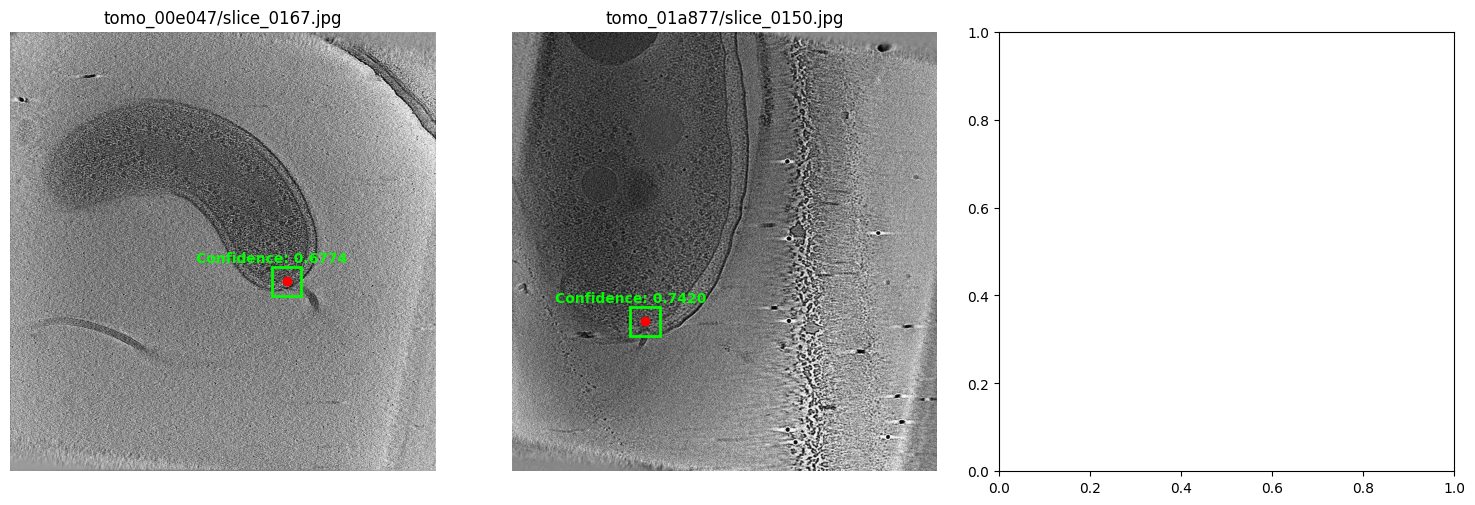

In [16]:
if len(final_predictions) == 3:
    points = []
    image_paths = []
    
    for i, r in final_predictions.iterrows():
        if (
            r['z'] != -1 and 
            r['y'] != -1 and 
            r['x'] != -1
        ):
            slice_num = int(r['z'])
            slice_str = f"{slice_num:04d}"
            image_path = f"/kaggle/input/byu-locating-bacterial-flagellar-motors-2025/test/{r['tomo_id']}/slice_{slice_str}.jpg"
            image_paths.append(image_path)
            points.append((r['x'], r['y'], r['confidence']))

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    box_size = 64
    half_box = box_size // 2

    for i, path in enumerate(image_paths):
        img = cv2.imread(path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img_rgb)
        x, y, confidence = points[i]
        
        axes[i].scatter(x, y, color="red")
        
        rect = patches.Rectangle((x - half_box, y - half_box), box_size, box_size, linewidth=2, edgecolor='lime', facecolor='none')
        axes[i].add_patch(rect)
        
        axes[i].text(x - half_box, y - half_box - 10, f"Confidence: {confidence:.4f}", color='lime', fontsize=10, weight='bold', ha='center')
        axes[i].set_title(path.split("/")[-2] + "/" + path.split("/")[-1])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [17]:
submission = final_predictions.copy()
submission = submission.rename(columns={"x": "Motor axis 2", "y": "Motor axis 1", "z": "Motor axis 0"})
submission = submission[['tomo_id', 'Motor axis 0', 'Motor axis 1', 'Motor axis 2']]
submission.to_csv("submission.csv", index=False)
submission.head()

,tomo_id,Motor axis 0,Motor axis 1,Motor axis 2
1,tomo_00e047,167,544,603
1,tomo_01a877,150,632,290
0,tomo_003acc,-1,-1,-1
